In [1]:
import mxnet
from mxnet import ndarray as nd
from time import time
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import re, itertools

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/steven/miniconda3/envs/dl/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7600 on context None
Mapped name None to device cuda: GeForce GTX 1070 with Max-Q Design (0000:01:00.0)


In [2]:
TRAIN_CSV = './data/train.csv'
EMBEDDING = './data/GoogleNews-vectors-negative300.bin.gz'
MODEL_DIR = './model/'

In [3]:
# control how many samples are read, due to memory limitation
nrows = 30000
train_df = pd.read_csv(TRAIN_CSV, nrows=nrows)
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text
# prepare embedding
vocab = dict()
inverse_vocab = ['<unk>']
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING, binary=True)

In [4]:
target_columns = ['review_text', 'plot_summary']
for index, row in train_df.iterrows():
    for column in target_columns:
        embedding = []
        for word in text_to_word_list(row[column]):
            if word in stops and word not in word2vec.vocab:
                continue
            if word not in vocab:
                vocab[word] = len(inverse_vocab)
                inverse_vocab.append(word)
            embedding.append(vocab[word])
        train_df.set_value(index, column, embedding)

embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocab) + 1, embedding_dim)
embeddings[0] = 0

for word, index in vocab.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)
del word2vec

/home/steven/miniconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [5]:
max_seq_length  = max(train_df.review_text.map(lambda x: len(x)).max(),
                      train_df.plot_summary.map(lambda x: len(x)).max())
valid_size = round(len(train_df) * .2)

X = train_df[target_columns]
Y = train_df['is_spoiler']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=valid_size)
X_train = {'left': X_train.review_text, 'right': X_train.plot_summary}
X_valid = {'left': X_valid.review_text, 'right': X_valid.plot_summary}
Y_train = Y_train.values
Y_valid = Y_valid.values

In [6]:
for dataset, side in itertools.product([X_train, X_valid], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

In [8]:
n_hidden = 16
batch_size = 128
n_epoch = 10

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], \
                            input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), \
                         output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, \
                            nb_epoch=n_epoch, validation_data=([X_valid['left'], X_valid['right']], \
                                                               Y_valid))

/home/steven/miniconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 425s 18ms/step - loss: 0.2057 - acc: 0.7350 - val_loss: 0.2057 - val_acc: 0.7295
Epoch 2/10
24000/24000 [==============================] - 425s 18ms/step - loss: 0.1981 - acc: 0.7357 - val_loss: 0.2031 - val_acc: 0.7295
Epoch 3/10
24000/24000 [==============================] - 415s 17ms/step - loss: 0.1945 - acc: 0.7364 - val_loss: 0.2017 - val_acc: 0.7298
Epoch 4/10
24000/24000 [==============================] - 421s 18ms/step - loss: 0.1920 - acc: 0.7368 - val_loss: 0.2008 - val_acc: 0.7287
Epoch 5/10
24000/24000 [==============================] - 413s 17ms/step - loss: 0.1898 - acc: 0.7376 - val_loss: 0.2004 - val_acc: 0.7285
Epoch 6/10
24000/24000 [==============================] - 407s 17ms/step - loss: 0.1882 - acc: 0.7378 - val_loss: 0.1998 - val_acc: 0.7287
Epoch 7/10
24000/24000 [==============================] - 406s 17ms/step - loss: 0.1867 - acc: 0.7385 - val_loss: 0.1

NameError: name 'datetime' is not defined

In [9]:
import datetime
print("Training time finished.\n{} epochs in {}".format(n_epoch, \
      datetime.timedelta(seconds=time()-training_start_time)))

Training time finished.
10 epochs in 1:11:18.377473


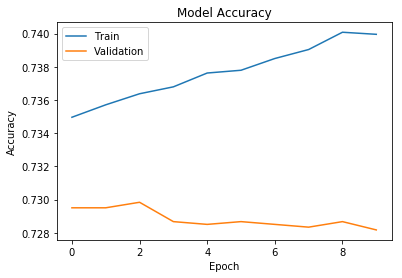

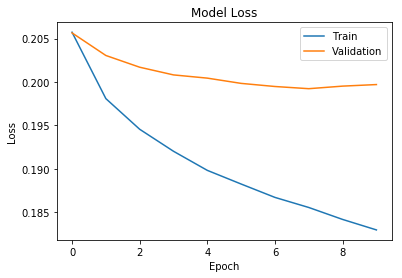

In [11]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [12]:
malstm.save('./model')